# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                
Sample_121  Q99985                                                           14.829
Sample_145  P01857                                                           25.996
Sample_011  A0A0G2JMC9;A0A0G2JMW8;A8MZH0;Q8N149;Q8N149-2;Q8N149-3;Q8N149-4   14.442
Sample_180  C9J0J0;Q96EE4                                                    11.732
Sample_015  P55087;P55087-2;V9PBN7                                           15.371
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                   
Sample_033  Q96GD0                                              13.319
Sample_161  P81605                                              15.797
Sample_008  D6RH31;Q6UXI9;Q6UXI9-3;Q6UXI9-4;Q6UXI9-5;Q6UXI9-6   14.610
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.312
            A0A075B6Q5                 13.454
            A0A075B6R2                 12.236
            A0A075B6S5                 11.841
            A0A087WSY4                 13.727
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.454
            Q9UI40;Q9UI40-2            12.196
            Q9UIW2                     12.402
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.999
            Q9UP79                     12.354
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.129,15.050,16.842,19.863,15.792,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.750,19.067,...,15.528,15.576,13.937,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.639,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.929,17.705,17.039,16.154,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.644,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.364,15.345,17.084,18.708,14.249,19.433,12.299,11.092
Sample_207,15.739,16.877,15.469,16.898,14.799,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.312,...,16.012,15.178,12.974,15.050,16.842,19.863,12.639,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.108,19.067,16.188,...,15.528,15.576,12.883,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.418,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.863,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.716,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.672,15.345,17.084,18.708,14.249,19.433,12.886,13.580
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 354.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.43it/s]

100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.48it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.69it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.12it/s]

100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.28it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.75it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.13it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

100%|██████████| 6/6 [00:01<00:00,  4.08it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.53it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.83it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.17it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.61it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.33it/s]

100%|██████████| 7/7 [00:01<00:00,  3.37it/s]

100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.26it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.32it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.70it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.47it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.52it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.47it/s]

100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.73it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.28it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.86it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.48it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.03it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.85it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.74it/s]

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.64it/s]

 30%|███       | 3/10 [00:00<00:01,  6.48it/s]

 40%|████      | 4/10 [00:00<00:01,  4.78it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.25it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.81it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.81it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.71it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.68it/s]

100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.27it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.63it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.83it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.94it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  3.00it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.96it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.97it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  3.06it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.00it/s]

100%|██████████| 11/11 [00:03<00:00,  2.61it/s]

100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.97it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.61it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.28it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.88it/s]

 50%|█████     | 6/12 [00:03<00:03,  1.71it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.73it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.74it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.94it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.05it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.34it/s]

100%|██████████| 12/12 [00:05<00:00,  2.56it/s]

100%|██████████| 12/12 [00:05<00:00,  2.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.39it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.93it/s]

 31%|███       | 4/13 [00:01<00:02,  3.60it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.47it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.54it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.44it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.31it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.35it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.90it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.34it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.05it/s]

100%|██████████| 13/13 [00:04<00:00,  1.88it/s]

100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.26it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.26it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.03it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.03it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.99it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.83it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.73it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.69it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.76it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.00it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.20it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.39it/s]

100%|██████████| 14/14 [00:06<00:00,  2.45it/s]

100%|██████████| 14/14 [00:06<00:00,  2.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.29it/s]

 20%|██        | 3/15 [00:00<00:03,  3.51it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.44it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.06it/s]

 40%|████      | 6/15 [00:01<00:03,  2.96it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.94it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.98it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.04it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.06it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.02it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.85it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.34it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.05it/s]

100%|██████████| 15/15 [00:05<00:00,  1.87it/s]

100%|██████████| 15/15 [00:05<00:00,  2.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.044 0.004          0.847 0.246       0.136   
2             0.003 0.000      0.046 0.001          0.707 0.092       0.603   
3             0.004 0.000      0.046 0.001          0.683 0.091       0.614   
4             0.004 0.000      0.045 0.001          0.710 0.082       0.667   
5             0.004 0.000      0.046 0.001          0.717 0.074       0.682   
6             0.004 0.000      0.045 0.002          0.801 0.088       0.830   
7             0.004 0.000      0.047 0.001          0.799 0.089       0.822   
8             0.004 0.000      0.046 0.002          0.805 0.088       0.805   
9             0.004 0.000      0.042 0.002          0.806 0.085       0.794   
10            0.008 0.008      0.085 0.049          0.808 0.082       0.790   
11            0.007 0.006      0.086 0.044          0.838 0.079       0.816   
12            0.005 0.004      0.070 0.035          0.821 0.082       0.814   
13            0.007 0.006      0.074 0.036          0.818 0.077       0.812   
14            0.006 0.005      0.071 0.035          0.800 0.078       0.808   
15            0.007 0.006      0.078 0.030          0.811 0.069       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.225 0.127                  0.560 0.042        0.857   
2          0.106   0.645 0.080                  0.708 0.060        0.787   
3          0.111   0.641 0.083                  0.701 0.062        0.774   
4          0.112   0.681 0.074                  0.732 0.055        0.784   
5          0.110   0.694 0.074                  0.742 0.057        0.812   
6          0.098   0.811 0.074                  0.838 0.065        0.902   
7          0.099   0.806 0.074                  0.833 0.064        0.900   
8          0.104   0.801 0.077                  0.830 0.066        0.900   
9          0.098   0.796 0.072                  0.826 0.061        0.914   
10         0.097   0.795 0.071                  0.825 0.059        0.913   
11         0.096   0.823 0.068                  0.849 0.056        0.915   
12         0.100   0.813 0.069                  0.841 0.059        0.914   
13         0.104   0.811 0.072                  0.839 0.060        0.911   
14         0.099   0.800 0.070                  0.829 0.060        0.910   
15         0.099   0.806 0.067                  0.835 0.056        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.085        210.000 0.000  
2          0.066                  0.761 0.084        210.000 0.000  
3          0.066                  0.750 0.084        210.000 0.000  
4          0.063                  0.749 0.084        210.000 0.000  
5          0.063                  0.784 0.082        210.000 0.000  
6          0.048                  0.877 0.058        210.000 0.000  
7          0.049                  0.872 0.061        210.000 0.000  
8          0.049                  0.870 0.063        210.000 0.000  
9          0.044                  0.898 0.050        210.000 0.000  
10         0.043                  0.897 0.049        210.000 0.000  
11         0.046                  0.904 0.047        210.000 0.000  
12         0.047                  0.904 0.047        210.000 0.000  
13         0.049                  0.901 0.048        210.000 0.000  
14         0.049                  0.900 0.049        210.000 0.000  
15         0.048                  0.901 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 482.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.71it/s]

100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.43it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

100%|██████████| 4/4 [00:01<00:00,  1.95it/s]

100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.24it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.71it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.19it/s]

100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.59it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.47it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.52it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.48it/s]

100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.07it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.53it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.19it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.96it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.96it/s]

100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.84it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.97it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.49it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.93it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.84it/s]

100%|██████████| 8/8 [00:03<00:00,  1.86it/s]

100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.52it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.69it/s]

 44%|████▍     | 4/9 [00:01<00:02,  1.96it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.73it/s]

 67%|██████▋   | 6/9 [00:03<00:01,  1.70it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.80it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.96it/s]

100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.64it/s]

 30%|███       | 3/10 [00:00<00:01,  3.53it/s]

 40%|████      | 4/10 [00:01<00:01,  3.11it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.96it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.96it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.41it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.21it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.00it/s]

100%|██████████| 10/10 [00:04<00:00,  1.79it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:03,  2.97it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.31it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.24it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.33it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.09it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.86it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.05it/s]

100%|██████████| 11/11 [00:05<00:00,  2.16it/s]

100%|██████████| 11/11 [00:05<00:00,  2.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.36it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.53it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.51it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.02it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.76it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.73it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.72it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.82it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.98it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.14it/s]

100%|██████████| 12/12 [00:05<00:00,  2.17it/s]

100%|██████████| 12/12 [00:05<00:00,  2.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.26it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.39it/s]

 31%|███       | 4/13 [00:01<00:03,  2.57it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.23it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.10it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.12it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.17it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.26it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.30it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.03it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.94it/s]

100%|██████████| 13/13 [00:06<00:00,  1.81it/s]

100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.88it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.22it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.25it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.10it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.77it/s]

 50%|█████     | 7/14 [00:03<00:04,  1.69it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.62it/s]

 64%|██████▍   | 9/14 [00:04<00:03,  1.61it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.70it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.80it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.83it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.97it/s]

100%|██████████| 14/14 [00:07<00:00,  2.17it/s]

100%|██████████| 14/14 [00:07<00:00,  1.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  3.13it/s]

 20%|██        | 3/15 [00:01<00:05,  2.37it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.06it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.08it/s]

 40%|████      | 6/15 [00:02<00:04,  2.06it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.19it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.01it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.85it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.82it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.87it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.04it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.14it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.25it/s]

100%|██████████| 15/15 [00:07<00:00,  2.32it/s]

100%|██████████| 15/15 [00:07<00:00,  2.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.007      0.077 0.032          0.000 0.000       0.000   
2             0.005 0.005      0.051 0.017          0.707 0.134       0.471   
3             0.006 0.005      0.070 0.030          0.728 0.122       0.584   
4             0.008 0.007      0.088 0.041          0.680 0.112       0.599   
5             0.007 0.007      0.083 0.046          0.718 0.099       0.593   
6             0.004 0.003      0.063 0.032          0.738 0.111       0.608   
7             0.004 0.003      0.053 0.017          0.728 0.105       0.624   
8             0.005 0.003      0.066 0.023          0.728 0.098       0.621   
9             0.006 0.006      0.082 0.043          0.822 0.093       0.767   
10            0.006 0.004      0.066 0.022          0.829 0.092       0.765   
11            0.006 0.004      0.080 0.032          0.821 0.092       0.775   
12            0.008 0.006      0.083 0.027          0.823 0.090       0.772   
13            0.007 0.006      0.072 0.028          0.833 0.085       0.804   
14            0.006 0.004      0.066 0.024          0.830 0.088       0.802   
15            0.006 0.006      0.085 0.028          0.825 0.086       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.007        0.846   
2          0.119   0.554 0.100                  0.658 0.064        0.687   
3          0.118   0.640 0.096                  0.709 0.069        0.752   
4          0.118   0.629 0.091                  0.693 0.067        0.754   
5          0.123   0.640 0.086                  0.708 0.059        0.781   
6          0.119   0.660 0.095                  0.723 0.069        0.781   
7          0.122   0.665 0.093                  0.725 0.069        0.787   
8          0.122   0.663 0.091                  0.724 0.067        0.783   
9          0.112   0.788 0.078                  0.821 0.062        0.878   
10         0.112   0.790 0.080                  0.823 0.063        0.877   
11         0.099   0.793 0.073                  0.824 0.061        0.907   
12         0.107   0.791 0.075                  0.823 0.062        0.907   
13         0.102   0.813 0.070                  0.841 0.059        0.912   
14         0.098   0.812 0.072                  0.839 0.060        0.912   
15         0.108   0.806 0.074                  0.836 0.062        0.912   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.819 0.086        210.000 0.000  
2          0.074                  0.676 0.085        210.000 0.000  
3          0.076                  0.718 0.098        210.000 0.000  
4          0.072                  0.708 0.093        210.000 0.000  
5          0.070                  0.750 0.089        210.000 0.000  
6          0.072                  0.761 0.086        210.000 0.000  
7          0.068                  0.761 0.083        210.000 0.000  
8          0.070                  0.758 0.084        210.000 0.000  
9          0.055                  0.851 0.068        210.000 0.000  
10         0.060                  0.851 0.074        210.000 0.000  
11         0.051                  0.883 0.058        210.000 0.000  
12         0.049                  0.883 0.057        210.000 0.000  
13         0.048                  0.889 0.056        210.000 0.000  
14         0.049                  0.889 0.056        210.000 0.000  
15         0.048                  0.891 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 914.59it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 15.10it/s]

100%|██████████| 3/3 [00:00<00:00, 12.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.74it/s]

100%|██████████| 4/4 [00:00<00:00, 15.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 19.92it/s]

 80%|████████  | 4/5 [00:00<00:00, 11.54it/s]

100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.29it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.28it/s]

100%|██████████| 6/6 [00:00<00:00, 13.19it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 18.89it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 11.88it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  9.65it/s]

100%|██████████| 7/7 [00:00<00:00,  9.77it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.84it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 10.33it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 10.21it/s]

100%|██████████| 8/8 [00:00<00:00,  9.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.29it/s]

 44%|████▍     | 4/9 [00:00<00:00,  9.76it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  8.10it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  8.02it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  7.76it/s]

100%|██████████| 9/9 [00:01<00:00,  7.79it/s]

100%|██████████| 9/9 [00:01<00:00,  8.25it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 11.85it/s]

 40%|████      | 4/10 [00:00<00:00, 10.08it/s]

 60%|██████    | 6/10 [00:00<00:00,  8.26it/s]

 70%|███████   | 7/10 [00:00<00:00,  8.04it/s]

 80%|████████  | 8/10 [00:00<00:00,  8.09it/s]

 90%|█████████ | 9/10 [00:01<00:00,  8.51it/s]

100%|██████████| 10/10 [00:01<00:00,  8.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.83it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 13.56it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.54it/s]

 91%|█████████ | 10/11 [00:00<00:00,  9.70it/s]

100%|██████████| 11/11 [00:01<00:00, 10.58it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.17it/s]

 42%|████▏     | 5/12 [00:00<00:00, 12.86it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.35it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.74it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.39it/s]

100%|██████████| 12/12 [00:00<00:00, 12.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.28it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.75it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.78it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.14it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.58it/s]

100%|██████████| 13/13 [00:01<00:00, 10.85it/s]

100%|██████████| 13/13 [00:01<00:00, 11.68it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 18.84it/s]

 29%|██▊       | 4/14 [00:00<00:00, 14.11it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.08it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.42it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.23it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.56it/s]

100%|██████████| 14/14 [00:01<00:00, 10.73it/s]

100%|██████████| 14/14 [00:01<00:00, 11.66it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 27.15it/s]

 40%|████      | 6/15 [00:00<00:00, 14.71it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 12.14it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.15it/s]

 80%|████████  | 12/15 [00:00<00:00, 11.81it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.16it/s]

100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.070 0.029          0.000 0.000       0.000   
2             0.005 0.004      0.088 0.032          0.578 0.143       0.312   
3             0.007 0.007      0.073 0.031          0.628 0.097       0.497   
4             0.007 0.006      0.078 0.038          0.641 0.101       0.512   
5             0.007 0.006      0.077 0.039          0.692 0.090       0.578   
6             0.006 0.008      0.068 0.031          0.680 0.106       0.575   
7             0.007 0.008      0.077 0.037          0.690 0.098       0.585   
8             0.004 0.003      0.055 0.020          0.694 0.096       0.577   
9             0.008 0.007      0.079 0.031          0.688 0.100       0.592   
10            0.006 0.005      0.062 0.025          0.685 0.099       0.579   
11            0.006 0.006      0.078 0.038          0.678 0.115       0.558   
12            0.007 0.006      0.080 0.036          0.697 0.109       0.587   
13            0.006 0.006      0.084 0.036          0.695 0.108       0.583   
14            0.006 0.006      0.079 0.034          0.682 0.101       0.623   
15            0.004 0.000      0.056 0.025          0.678 0.106       0.614   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.717   
2          0.100   0.395 0.103                  0.568 0.060        0.626   
3          0.098   0.548 0.082                  0.638 0.058        0.711   
4          0.101   0.565 0.090                  0.651 0.065        0.735   
5          0.099   0.625 0.078                  0.694 0.059        0.769   
6          0.101   0.618 0.083                  0.686 0.064        0.775   
7          0.102   0.627 0.078                  0.693 0.059        0.773   
8          0.088   0.624 0.068                  0.692 0.052        0.770   
9          0.099   0.630 0.074                  0.694 0.057        0.771   
10         0.097   0.620 0.071                  0.688 0.053        0.767   
11         0.121   0.604 0.098                  0.679 0.071        0.764   
12         0.115   0.630 0.092                  0.696 0.071        0.774   
13         0.115   0.626 0.091                  0.694 0.069        0.771   
14         0.113   0.645 0.085                  0.702 0.070        0.784   
15         0.121   0.638 0.095                  0.698 0.075        0.781   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.670 0.087        210.000 0.000  
2          0.074                  0.585 0.078        210.000 0.000  
3          0.062                  0.655 0.079        210.000 0.000  
4          0.067                  0.697 0.077        210.000 0.000  
5          0.067                  0.730 0.081        210.000 0.000  
6          0.066                  0.737 0.076        210.000 0.000  
7          0.065                  0.740 0.071        210.000 0.000  
8          0.069                  0.736 0.070        210.000 0.000  
9          0.069                  0.737 0.073        210.000 0.000  
10         0.070                  0.736 0.073        210.000 0.000  
11         0.069                  0.730 0.074        210.000 0.000  
12         0.070                  0.736 0.078        210.000 0.000  
13         0.070                  0.733 0.077        210.000 0.000  
14         0.073                  0.751 0.077        210.000 0.000  
15         0.073                  0.747 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,12,9
score_time,11,4,2
test_precision,1,13,12
test_recall,6,13,14
test_f1,11,13,14
test_balanced_accuracy,11,13,14
test_roc_auc,11,13,14
test_average_precision,12,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.30it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.32it/s]

 31%|███       | 4/13 [00:01<00:02,  3.19it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.09it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.91it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.89it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.56it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.62it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.47it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.35it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.49it/s]

100%|██████████| 13/13 [00:04<00:00,  2.66it/s]

100%|██████████| 13/13 [00:04<00:00,  2.76it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.94it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.40it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.62it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.27it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.15it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.24it/s]

100%|██████████| 14/14 [00:01<00:00, 12.42it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.49it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.88it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.22it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.83it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.57it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.41it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.28it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.52it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.66it/s]

100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


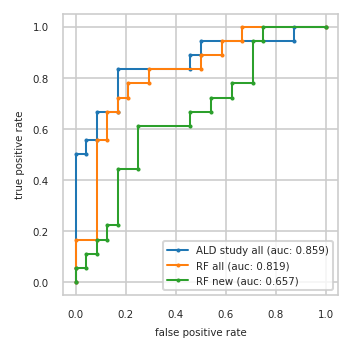

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.167  0.042 0.056
3          0.042 0.500  0.083 0.167  0.042 0.111
4          0.042 0.556  0.083 0.556  0.083 0.111
5          0.083 0.556  0.125 0.556  0.083 0.167
6          0.083 0.667  0.125 0.667  0.125 0.167
7          0.167 0.667  0.167 0.667  0.125 0.222
8          0.167 0.833  0.167 0.722  0.167 0.222
9          0.458 0.833  0.208 0.722  0.167 0.444
10         0.458 0.889  0.208 0.778  0.250 0.444
11         0.500 0.889  0.292 0.778  0.250 0.611
12         0.500 0.944  0.292 0.833  0.458 0.611
13         0.875 0.944  0.500 0.833  0.458 0.667
14         0.875 1.000  0.500 0.889  0.542 0.667
15         1.000 1.000  0.583 0.889  0.542 0.722
16           NaN   NaN  0.583 0.944  0.625 0.722
17           NaN   NaN  0.667 0.944  0.625 0.778
18           NaN   NaN  0.667 1.000  0.708 0.778
19           NaN   NaN  1.000 1.000  0.708 0.944
20           NaN   NaN    NaN   NaN  0.750 0.944
21           NaN   NaN    NaN   NaN  0.750 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,P01597;P04432,P60709;P63261,P36269;P36269-2;P36269-3
2,D6RF86;P55285;P55285-2,F8WE04;P04792,Q96GD0
3,P61981,P10636-2;P10636-6,Q9NUQ9
4,P04075,P04075,A0A075B7B8
5,Q02818,C9JIZ6;P07602;P07602-2;P07602-3,Q9Y281;Q9Y281-3
6,P14174,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P14618,P61981,E5RK69;E7EMC6;P08133;P08133-2
8,P00338;P00338-3,P25189;P25189-2,P31321


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


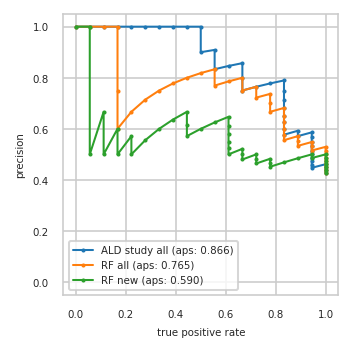

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.515 0.944     0.485 0.889
10         0.531 0.944     0.531 0.944     0.469 0.833
11         0.548 0.944     0.548 0.944     0.452 0.778
12         0.567 0.944     0.533 0.889     0.467 0.778
13         0.586 0.944     0.552 0.889     0.483 0.778
14         0.571 0.889     0.571 0.889     0.464 0.722
15         0.593 0.889     0.556 0.833     0.481 0.722
16         0.577 0.833     0.577 0.833     0.500 0.722
17         0.600 0.833     0.600 0.833     0.480 0.667
18         0.625 0.833     0.625 0.833     0.500 0.667
19         0.652 0.833     0.652 0.833     0.522 0.667
20         0.682 0.833     0.682 0.833     0.500 0.611
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.737 0.778     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.765 0.722     0.765 0.722     0.647 0.611
26         0.750 0.667     0.750 0.667     0.625 0.556
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.615 0.444
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.750 0.333     0.500 0.222
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.667 0.222     0.500 0.167
37         1.000 0.278     0.600 0.167     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


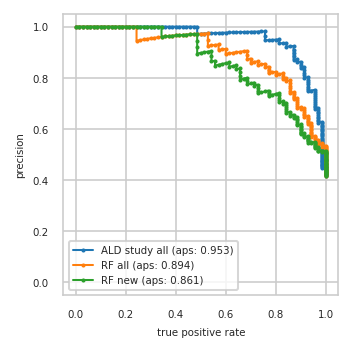

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


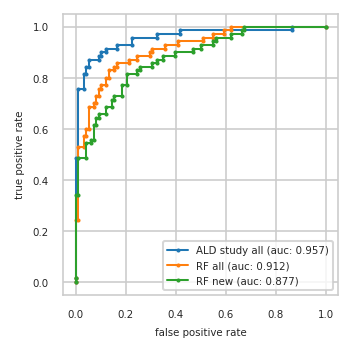

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}